In [2]:
import pandas as pd
from wordcloud import WordCloud
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import math
import stanza

%matplotlib inline

<ipython-input-3-feb503554226>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_year["preprocessed_xpo"][group_year.preprocessed_xpo == False] = "XPO ou Communiqué"


preprocessed_xpo  Pas de documents  XPO ou Communiqué
year                                                 
2007                             1                 19
2008                            16                 37
2009                             7                 34
2010                            23                 40
2011                            24                 35
2012                            20                 22
2013                            20                 44
2014                            25                 35
2015                            21                 46
2016                            32                 33
2017                            11                 25
2018                            18                 27
2019                            23                 26
2020                            16                 31
2021                            16                 18


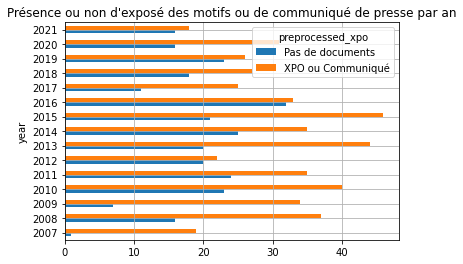

In [3]:
df = pd.read_excel("./Exports/final_export.xlsx")

import matplotlib.pyplot as plt
%matplotlib inline

group_year = df

group_year["preprocessed_xpo"] = group_year.preprocessed_xpo.isna()
group_year["preprocessed_xpo"][group_year.preprocessed_xpo == False] = "XPO ou Communiqué"
group_year["preprocessed_xpo"][group_year.preprocessed_xpo == True] = "Pas de documents"

group_year = group_year.groupby('year').preprocessed_xpo.value_counts().sort_index()
group_year = group_year.unstack()
group_year.plot.barh(grid=True, title="Présence ou non d'exposé des motifs ou de communiqué de presse par an")
print(group_year)

## Quelles lois n'ont pas d'exposé des motifs ?

In [4]:
df = pd.read_excel("./Exports/final_export.xlsx")
SXpo = df[["preprocessed_xpo", "titre"]]
SXpo = SXpo.loc[SXpo.preprocessed_xpo.isna()]
for item in SXpo.titre:
    SXpo.titre.loc[SXpo.titre == item] = re.sub("LOI", "", item)
    item = re.sub("LOI", "", item)
    SXpo.titre.loc[SXpo.titre == item] = re.sub("n°", "", item)
    item = re.sub("n°", "", item)
    SXpo.titre.loc[SXpo.titre == item] = re.sub("\d", "", item)
    item = re.sub("\d", "", item)
    SXpo.titre.loc[SXpo.titre == item] = re.sub("janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre", "", item)
    item = re.sub("janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre", "", item)
    SXpo.titre.loc[SXpo.titre == item] = re.sub("- du", "", item)
    item = re.sub("- du", "", item)
#    SXpo.titre.loc[SXpo.titre == item] = re.sub("organique -", "", item)
#    item = re.sub("organique", "", item)
    
SXpo

,preprocessed_xpo,titre
0,NaN,relative aux mesures conservatoires en m...
3,NaN,visant à sécuriser les droits à protecti...
5,NaN,portant simplification de dispositions d...
14,NaN,d'expérimentation territoriale visant à ...
15,NaN,pour le développement de l'alternance et...
...,...,...
733,NaN,encadrant les conditions de la vente à d...
736,NaN,relative à l'équipement numérique des ét...
737,NaN,visant à moderniser les outils et la gou...
739,NaN,organique portant diverses dispositions ...


In [5]:
title = [titre[1] for titre in SXpo.titre.items()]
title

["      relative aux mesures conservatoires en matière de procédures de sauvegarde, de redressement judiciaire ou de liquidation judiciaire et aux biens qui en font l'objet",
 '      visant à sécuriser les droits à protection sociale des assistants maternels et des salariés des particuliers employeurs',
 '      portant simplification de dispositions du code électoral et relative à la transparence financière de la vie politique',
 "      d'expérimentation territoriale visant à résorber le chômage de longue durée",
 "      pour le développement de l'alternance et la sécurisation des parcours professionnels",
 '      visant à reconnaître le vote blanc aux élections',
 '      relative à la gouvernance de la sécurité sociale et à la mutualité',
 "      relative à l'élection des conseillers municipaux dans les communes associées de la Polynésie française et à la modernisation du code général des collectivités territoriales applicable aux communes de la Polynésie française, à leurs groupement

In [6]:
def top_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids if row[i]>0]
    df = pd.DataFrame(top_feats)
    if len(top_feats) > 0:
        df.columns = ['feature', 'score']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_feats(row, features, top_n)

In [8]:
import string

with open("./stopwords/Stop-words-french.txt", "r", encoding='utf8') as f:
    stopW1 = [line.rstrip("\n") for line in f.readlines()]
with open("./stopwords/stopword.txt", "r", encoding='utf8') as f:
    stopW2 = [line.rstrip("\n") for line in f.readlines()]
stopW = stopW1 + stopW2 #+ stopwords.words("french")
stopW.extend(string.punctuation)
stopW.extend(['’', '«', '»', '…', '—','».', '»,', '---', '.—', '…—', 'ans', 'an'])

In [9]:
tf_vectorizer = CountVectorizer(stop_words=stopW)
tf_vectorizer.fit(title)

X = tf_vectorizer.transform(title)
X = X.toarray()
features = tf_vectorizer.get_feature_names()

(num_doc, num_f) = X.shape

tf_sum = np.sum(X, axis=0)
tf = top_feats(tf_sum, features)
top_feats(tf_sum, features)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abord', 'ain', 'aren', 'assemblée', 'aujourd', 'bicaméralisme', 'bicamérisme', 'budgétaire', 'cavalier', 'confiance', 'conférence', 'conseil', 'constitutionnel', 'constitutionnelle', 'couldn', 'didn', 'doesn', 'don', 'doute', 'délégation', 'enquête', 'exposé', 'financement', 'finances', 'groupe', 'hadn', 'hasn', 'haven', 'hui', 'isn', 'jour', 'journal', 'll', 'mal', 'mdr', 'ministres', 'mixte', 'motifs', 'motion', 'nationale', 'officiel', 'ordre', 'organique', 'paritaire', 'parlementaire', 'politique', 'programme', 'proposition', 'président', 'présidents', 'publique', 'puisqu', 'question', 'ratification', 'shouldn', 'sociale', 'sommaire', 'séance', 'sécurite', 'temps', 'traités', 've', 'wasn', 'weren', 'won', 'wouldn', 'êetre'] not in stop_words.
  warnings.warn('Your stop_words may be i

,feature,score
0,relative,114
1,visant,71
2,tendant,26
3,contre,26
4,portant,22
5,er,21
6,organique,18
7,lutte,14
8,protection,13
9,diverses,12


In [10]:
words = tf['feature'][0:5]
words = words.append(tf['feature'][6:7])
print(words)

for i in range(len(title)):
    for word in words:
        title[i] = re.sub(word, "", title[i])
    title[i] = re.sub(" er", "", title[i])
    title[i] = re.sub("modifiant", "", title[i])
#    title[i] = re.sub("relative", "", title[i])
#    title[i] = re.sub("mesure", "", title[i])
#    title[i] = re.sub("procédures", "", title[i])
#    title[i] = re.sub("dispositions", "", title[i])
#    title[i] = re.sub("visant", "", title[i])
#    title[i] = re.sub("objet", "", title[i])
#    title[i] = re.sub("tendant", "", title[i])
#    title[i] = re.sub("portant", "", title[i])
#    title[i] = re.sub("er", "", title[i])

0     relative
1       visant
2      tendant
3       contre
4      portant
6    organique
Name: feature, dtype: object


In [11]:
tf_vectorizer.fit(title)
X = tf_vectorizer.transform(title)
X = X.toarray()
features = tf_vectorizer.get_feature_names()

(num_doc, num_f) = X.shape

tf_sum = np.sum(X, axis=0)
tf = top_feats(tf_sum, features)
top_feats(tf_sum, features)

,feature,score
0,lutte,14
1,protection,13
2,diverses,12
3,communes,11
4,renforcer,10
5,améliorer,10
6,santé,9
7,création,8
8,simplification,8
9,sécurité,8


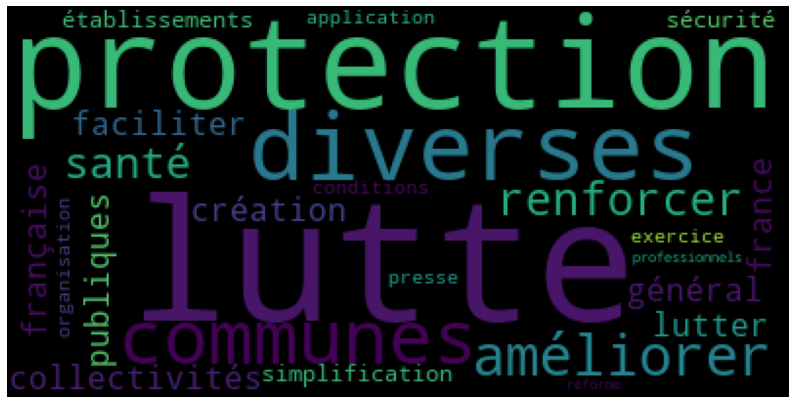

In [13]:
# les "labels" du nuage sont les mots
cloud_labels = features
# les poids correspondent à la somme des TF selon les lignes de la matrice
cloud_weights = tf_sum  #axis=0 ça veut dire qu'on prend les colonnes
# on construit un dictionnaire qui associe chaque label (mot) au poids correspondant (TF total)
dictionary = dict(zip(cloud_labels, cloud_weights)) # zip "colle" le vecteur des labels au vecteur des poids
# on trie par ordre décroissant
sorted_by_value = sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True) #On dit qu'on trie à partir de la valeur située en 1 (donc le poids)

limit = 25
fontcolor='#fafafa'
bgcolor = '#000000'

wordcloud = WordCloud(
    max_words=limit,
    background_color=bgcolor,
).fit_words(dictionary)

fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [12]:
titre = title
print(titre[1])
SXpo.reset_index(inplace=True, drop=False)
for i in range(len(titre)):
    titre[i] = nltk.tokenize.word_tokenize(titre[i])
    titre[i] = [word for word in titre[i] if word not in stopW]

    SXpo.titre[i] = titre[i]
#    SXpo.titre[i] = titre[i]
SXpo.titre.head()

       à sécuriser les droits à protection sociale des assistants maternels et des salariés des particuliers employeurs


<ipython-input-12-ef3064f777fa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SXpo.titre[i] = titre[i]


0    [mesures, conservatoires, procédures, sauvegar...
1    [sécuriser, protection, sociale, assistants, m...
2    [simplification, électoral, transparence, fina...
3    [d'expérimentation, territoriale, résorber, ch...
4    [développement, l'alternance, sécurisation, pa...
Name: titre, dtype: object

In [14]:
SXpo.titre

0      [mesures, conservatoires, procédures, sauvegar...
1      [sécuriser, protection, sociale, assistants, m...
2      [simplification, électoral, transparence, fina...
3      [d'expérimentation, territoriale, résorber, ch...
4      [développement, l'alternance, sécurisation, pa...
                             ...                        
268    [encadrant, conditions, vente, distance, livre...
269    [l'équipement, numérique, établissements, spec...
270    [moderniser, outils, gouvernance, Fondation, p...
271           [diverses, collectivité, Saint-Barthélemy]
272    [nomination, président, Commission, nationale,...
Name: titre, Length: 273, dtype: object

In [15]:
for i in range(len(titre)):
    temp = ""
    for word in titre[i]:
        temp = temp + " " + word
    SXpo.titre[i] = temp
print(SXpo.titre)

0       mesures conservatoires procédures sauvegarde ...
1       sécuriser protection sociale assistants mater...
2       simplification électoral transparence financi...
3       d'expérimentation territoriale résorber chôma...
4       développement l'alternance sécurisation parco...
                             ...                        
268     encadrant conditions vente distance livres ha...
269     l'équipement numérique établissements spectac...
270     moderniser outils gouvernance Fondation patri...
271               diverses collectivité Saint-Barthélemy
272     nomination président Commission nationale con...
Name: titre, Length: 273, dtype: object


<ipython-input-15-9c025a3c371f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SXpo.titre[i] = temp


### On peut essayer de regarder combien de textes de lois se rapporte à chacun de ces mots

In [16]:
tf_vectorizer.fit(SXpo.titre)
X_hp = tf_vectorizer.transform(SXpo.titre)
features_hp = tf_vectorizer.get_feature_names()

SXpo['category'] = ["" for i in range(len(SXpo.titre))]

i = 0
for titre1 in SXpo.titre:
    cat = top_feats_in_doc(X_hp, features_hp, i, 1)
#    print(titre1, "&", cat.feature.item())
#    if cat.feature.item() in tf.feature.values:
#        print(cat.feature.item())
    SXpo['category'].loc[SXpo.titre == titre1] = cat.feature.item()
    i += 1
    
SXpo

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,index,preprocessed_xpo,titre,category
0,0,NaN,mesures conservatoires procédures sauvegarde ...,judiciaire
1,3,NaN,sécuriser protection sociale assistants mater...,maternels
2,5,NaN,simplification électoral transparence financi...,transparence
3,14,NaN,d'expérimentation territoriale résorber chôma...,territoriale
4,15,NaN,développement l'alternance sécurisation parco...,parcours
...,...,...,...,...
268,733,NaN,encadrant conditions vente distance livres ha...,modifier
269,736,NaN,l'équipement numérique établissements spectac...,numérique
270,737,NaN,moderniser outils gouvernance Fondation patri...,moderniser
271,739,NaN,diverses collectivité Saint-Barthélemy,collectivité


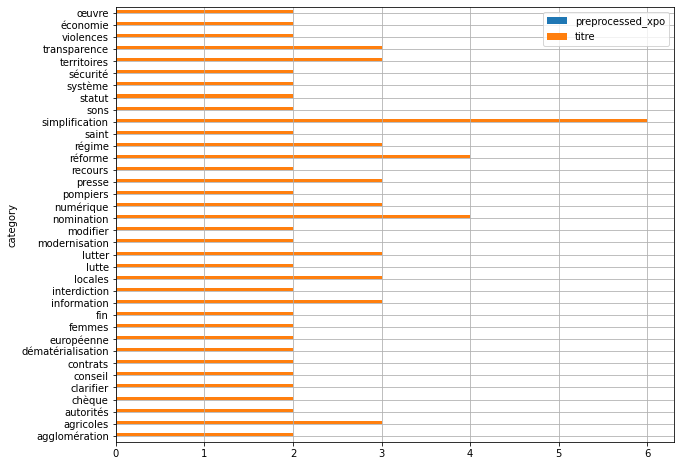

In [17]:
group_cat = SXpo.groupby('category').count().sort_index()

group_cat = group_cat.iloc[1:len(group_cat),1:3]

#print(group_cat)

g = group_cat.loc[group_cat.titre > 1].plot(kind="barh", grid=True, figsize=(10, 8))

### On peut chercher à comprendre le contexte de chacun de ces mots, en particulier ceux qui peuvent se rapporter à des problématiques sécuritaires en regardant les co-occurences de mots

In [24]:
t_freq = np.where(cloud_weights>2)
#print(t_freq[0])
index = t_freq[0]
X_small = X[:,index]
features_small = np.array(features)[index]
print(X_small.shape)

(_,num_f_small) = X_small.shape

print("Nombre de colonnes = mots : " + str(num_f_small))

(273, 183)
Nombre de colonnes = mots : 183


In [26]:
co_occ = np.matmul(X_small.transpose(), X_small)
for i in range(len(features_small)):
    id_mot = np.where(features_small == features_small[i])[0][0]
    scores_coocc = co_occ[id_mot,:]
    dico_co_occ = dict(zip(features_small, scores_coocc))
    mots_coocc = sorted(dico_co_occ.items(), key=lambda kv: kv[1], reverse=True)
    
    if mots_coocc[1][1] > 2:
#    if features_small[i] == "protection" or features_small[i] == "lutte" or features_small[i] == "sécurité":
        print("[{}] apparaît le plus avec {}".format(features_small[i], mots_coocc[1:4]))

[actes] apparaît le plus avec [('victimes', 3), ('améliorer', 1), ('charge', 1)]
[administratives] apparaît le plus avec [('indépendantes', 5), ('administratives', 4), ('publiques', 2)]
[agglomération] apparaît le plus avec [('communautés', 3), ('syndicats', 2), ('communes', 1)]
[appelant] apparaît le plus avec [('application', 4), ('administration', 2), ('communes', 2)]
[application] apparaît le plus avec [('appelant', 4), ('communes', 3), ('administration', 2)]
[assainissement] apparaît le plus avec [('eau', 3), ('communautés', 1), ('communes', 1)]
[assistants] apparaît le plus avec [('maternels', 5), ('création', 2), ('diverses', 2)]
[autorités] apparaît le plus avec [('indépendantes', 9), ('administratives', 5), ('publiques', 4)]
[barthélemy] apparaît le plus avec [('barthélemy', 3), ('collectivités', 1), ('diverses', 1)]
[charge] apparaît le plus avec [('prise', 3), ('actes', 1), ('aidants', 1)]
[collectivités] apparaît le plus avec [('territoriales', 7), ('coopération', 3), ('fra

## COLLOCATION

In [27]:
from nltk.tokenize import word_tokenize

words = [w.lower() for titre in SXpo.titre for w in word_tokenize(titre)]
print(words[0:100])

['mesures', 'conservatoires', 'procédures', 'sauvegarde', 'redressement', 'judiciaire', 'liquidation', 'judiciaire', 'biens', "l'objet", 'sécuriser', 'protection', 'sociale', 'assistants', 'maternels', 'salariés', 'particuliers', 'employeurs', 'simplification', 'électoral', 'transparence', 'financière', 'vie', 'politique', "d'expérimentation", 'territoriale', 'résorber', 'chômage', 'longue', 'durée', 'développement', "l'alternance", 'sécurisation', 'parcours', 'professionnels', 'reconnaître', 'vote', 'blanc', 'gouvernance', 'sécurité', 'sociale', 'mutualité', "l'élection", 'conseillers', 'municipaux', 'communes', 'associées', 'polynésie', 'française', 'modernisation', 'général', 'collectivités', 'territoriales', 'applicable', 'communes', 'polynésie', 'française', 'groupements', 'établissements', 'publics', 'certaines', 'issues', 'protection', 'faisant', "l'objet", 'soins', 'psychiatriques', 'prise', 'charge', "l'engagement", 'sapeurs-pompiers', 'volontaires', 'juridique', 'statut', 'té

In [28]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

bcf = BigramCollocationFinder.from_words(words)
bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)

[('collectivités', 'territoriales'),
 ("n'appelant", "d'application"),
 ("l'union", 'européenne'),
 ('polynésie', 'française'),
 ("d'inscription", 'listes'),
 ('répartition', 'sièges'),
 ('loi', "n'appelant"),
 ('listes', 'électorales'),
 ('rénovant', "d'inscription"),
 ('sièges', 'conseiller')]

In [44]:
filter_stops = lambda w: w in stopW or len(w) <= 3 
bcf.apply_word_filter(filter_stops)
liste = bcf.nbest(BigramAssocMeasures.likelihood_ratio, 100) #[num_f]
for item in liste:
    if "sécurité" in item:
        print(item)
#liste

('sécurité', 'publique')


In [761]:
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures

tcf = TrigramCollocationFinder.from_words(words)
tcf.apply_word_filter(filter_stops)
tcf.apply_freq_filter(3)
tcf.nbest(TrigramAssocMeasures.likelihood_ratio, 20)

[('général', 'collectivités', 'territoriales'),
 ('autorités', 'administratives', 'indépendantes'),
 ("d'inscription", 'listes', 'électorales'),
 ('rénovant', "d'inscription", 'listes'),
 ('répartition', 'sièges', 'conseiller')]

### On peut également réaliser un moteur de recherce pour voir dans quel contexte apparaîssent les mots, avec plus de précision que les collocations ou les co-occurences

In [33]:
tf_vectorizer = CountVectorizer(stop_words=stopW)

In [31]:
def cosinus(i, j):
    num = np.dot(i, j)
    den = math.sqrt(sum(i*i))*math.sqrt(sum(j*j))
    if (den>0):    
        return (num/den)
    else:
        return 0
    
def search(q, D, n_docs):
    cc = {i: cosinus(D[i, :], q) for i in range(n_docs)}
    cc = sorted(cc.items(), key=lambda x: x[1], reverse=True)
    return cc

def askforwords(queries):
    word = input("Quels mots cherchez-vous ? :  \n")
    if word != 'n' or word != '':
        queries = queries + [w for w in nltk.tokenize.word_tokenize(word)]

    answer = input("Souhaitez vous ajouter d'autres mots ? [y/n]  \n")
    if answer == 'n':
        return(queries)
    elif answer == 'y':
        askforwords(queries)
    else:
        print("ce paramètre n'est pas correct")
    
    return(queries)

In [35]:
def moteur(corpus):

    tf_vectorizer.fit(corpus)
    X_hp = tf_vectorizer.transform(corpus)
    features_hp = tf_vectorizer.get_feature_names()
    X = X_hp.toarray()

    n_docs, n_terms = X.shape

    tf_sum = np.sum(X, axis=0)

    Queries = []
    Queries = askforwords(Queries)

#On créé un index, dans lequel on note la position des mots, s'il existe dans les mots du coprus

    indexes = [features_hp.index(q) for q in Queries if q in features_hp]
    print(indexes)

#On crée un tableau remplit de la longueur du nombre de mots qu'on remplit de 0, 
# avant de mettre des 1 au position des mots que l'on cherche

    query_vec = np.zeros(n_terms)
    query_vec[indexes] = 1

    result = search(query_vec, X)

    nb_top_docs = n_docs
    top_docs = [r for (r,v) in result[0:nb_top_docs] if v != 0.0]

    for i, td in zip(range(10), top_docs[0:10]):
    #    print(top_feats_in_doc(X_hp, features_hp, td))
        print("%s (%s): %s" % (i+1, td, corpus[td][0:400]), result[i][1])

In [765]:
moteur(SXpo.titre)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abord', 'ain', 'aren', 'assemblée', 'aujourd', 'bicaméralisme', 'bicamérisme', 'budgétaire', 'cavalier', 'confiance', 'conférence', 'conseil', 'constitutionnel', 'constitutionnelle', 'couldn', 'didn', 'doesn', 'don', 'doute', 'délégation', 'enquête', 'exposé', 'financement', 'finances', 'groupe', 'hadn', 'hasn', 'haven', 'hui', 'isn', 'jour', 'journal', 'll', 'mal', 'mdr', 'ministres', 'mixte', 'motifs', 'motion', 'nationale', 'officiel', 'ordre', 'organique', 'paritaire', 'parlementaire', 'politique', 'programme', 'proposition', 'président', 'présidents', 'publique', 'puisqu', 'question', 'ratification', 'shouldn', 'sociale', 'sommaire', 'séance', 'sécurite', 'temps', 'traités', 've', 'wasn', 'weren', 'won', 'wouldn', 'êetre'] not in stop_words.
  warnings.warn('Your stop_words may be i

Quels mots cherchez-vous ? :  
bla
Souhaitez vous ajouter d'autres mots ? [y/n]  
n
[]


In [766]:
SXpo.iloc[163]

index                                  448
preprocessed_xpo                       NaN
titre                protection l'identité
category                          identité
Name: 163, dtype: object

### On peut utiliser le moteur de recherche pour revoir nos catégories

In [36]:
test = SXpo
test

,index,preprocessed_xpo,titre,category
0,0,NaN,mesures conservatoires procédures sauvegarde ...,judiciaire
1,3,NaN,sécuriser protection sociale assistants mater...,maternels
2,5,NaN,simplification électoral transparence financi...,transparence
3,14,NaN,d'expérimentation territoriale résorber chôma...,territoriale
4,15,NaN,développement l'alternance sécurisation parco...,parcours
...,...,...,...,...
268,733,NaN,encadrant conditions vente distance livres ha...,modifier
269,736,NaN,l'équipement numérique établissements spectac...,numérique
270,737,NaN,moderniser outils gouvernance Fondation patri...,moderniser
271,739,NaN,diverses collectivité Saint-Barthélemy,collectivité


In [37]:
def moteur2(corpus, Queries, tmp):
    
    tf_vectorizer.fit(corpus)
    X_hp = tf_vectorizer.transform(corpus)
    features_hp = tf_vectorizer.get_feature_names()
#    if Queries in features_hp:
#        print(features_hp.index(Queries))
#    else:
#        print("nope")
    X = X_hp.toarray()

    n_docs, n_terms = X.shape

    tf_sum = np.sum(X, axis=0)

#On créé un index, dans lequel on note la position des mots, s'il existe dans les mots du coprus

    indexes = [features_hp.index(Queries)]
#    print(indexes)

#On crée un tableau remplit de la longueur du nombre de mots qu'on remplit de 0, 
# avant de mettre des 1 au position des mots que l'on cherche

    query_vec = np.zeros(n_terms)
    query_vec[indexes] = 1

    result = search(query_vec, X, n_docs)

    nb_top_docs = n_docs
    top_docs = [r for (r,v) in result[0:nb_top_docs] if v != 0.0]

    for i, td in zip(range(10), top_docs[0:10]):
    #    print(top_feats_in_doc(X_hp, features_hp, td))
        tmp["Category"].iloc[td].append([Queries, result[i][1]])
    return(tmp)

In [38]:
tmp = pd.DataFrame()
tmp['Category'] = [[] for i in range(len(test.titre))]

print(type(test.titre))

for word in cloud_labels:
#    print(word)
    tmp = moteur2(test.titre, word, tmp)

tmp

<class 'pandas.core.series.Series'>


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abord', 'ain', 'aren', 'assemblée', 'aujourd', 'bicaméralisme', 'bicamérisme', 'budgétaire', 'cavalier', 'confiance', 'conférence', 'conseil', 'constitutionnel', 'constitutionnelle', 'couldn', 'didn', 'doesn', 'don', 'doute', 'délégation', 'enquête', 'exposé', 'financement', 'finances', 'groupe', 'hadn', 'hasn', 'haven', 'hui', 'isn', 'jour', 'journal', 'll', 'mal', 'mdr', 'ministres', 'mixte', 'motifs', 'motion', 'nationale', 'officiel', 'ordre', 'organique', 'paritaire', 'parlementaire', 'politique', 'programme', 'proposition', 'président', 'présidents', 'publique', 'puisqu', 'question', 'ratification', 'shouldn', 'sociale', 'sommaire', 'séance', 'sécurite', 'temps', 'traités', 've', 'wasn', 'weren', 'won', 'wouldn', 'êetre'] not in stop_words.
  warnings.warn('Your stop_words may be i

,Category
0,"[[biens, 0.2886751345948129], [conservatoires,..."
1,"[[assistants, 0.35355339059327373], [employeur..."
2,"[[financière, 0.4082482904638631], [politique,..."
3,"[[chômage, 0.4082482904638631], [durée, 0.4082..."
4,"[[alternance, 0.4472135954999579], [développem..."
...,...
268,"[[conditions, 0.2773500981126146], [contrat, 0..."
269,"[[cinématographiques, 0.4472135954999579], [nu..."
270,"[[fondation, 0.4472135954999579], [gouvernance..."
271,"[[barthélemy, 0.5], [collectivité, 0.5], [dive..."


In [892]:
#for i in range(len(test)):
#    print(tmp.loc[i], test.titre.loc[i], '\n')

In [39]:
test.category = ["" for i in range(len(test))]
temp = tmp


for i in range(len(test)):
    item = temp.Category.iloc[i]
#    print(item)
    if len(item) == 1:
        test.category.iloc[i] = item[0][0]
        print("ive been there {}".format(i))
    elif len(item) > 1:
        j = 1
        sub = []
        lenght = len(item)
        while j < lenght:
            sub = item[j][1]
            if item[0][1] > sub:
                j+=1
            elif item[0][1] < sub:
                tempo = item[0][1]
                print(tempo, sub)
                item[0][1] = sub
                item[j][1] = tempo
                j+=1
            else:
                if item[0][0] in tf.feature and sub not in tf.feature:
                    j+=1
                elif item[0][0] not in tf.feature and sub in tf.feature:
                    tempo = item[0][1]
                    print(tempo, sub)
                    item[0][1] = sub
                    item[j][1] = tempo
                    j+=1
                else:
                    j+=1
        test.category.iloc[i] = item[0][0]
        print("ive been there 2 {} : {} / {}".format(i, len(item), j))
        print(item[0][1])
        print(item[1][1])
#        print(test.category.iloc[i])
    print("ive been here {}".format(i))
test.category

0.2886751345948129 0.5773502691896258
ive been there 2 0 : 9 / 9
0.5773502691896258
0.2886751345948129
ive been here 0
ive been there 2 1 : 8 / 8
0.35355339059327373
0.35355339059327373
ive been here 1
ive been there 2 2 : 6 / 6
0.4082482904638631
0.4082482904638631
ive been here 2
ive been there 2 3 : 6 / 6
0.4082482904638631
0.4082482904638631
ive been here 3
ive been there 2 4 : 5 / 5
0.4472135954999579
0.4472135954999579
ive been here 4
ive been there 2 5 : 3 / 3
0.5773502691896258
0.5773502691896258
ive been here 5
ive been there 2 6 : 4 / 4
0.5
0.5
ive been here 6
0.20412414523193154 0.4082482904638631
ive been there 2 7 : 15 / 15
0.4082482904638631
0.20412414523193154
ive been here 7
ive been there 2 8 : 8 / 8
0.3333333333333333
0.3333333333333333
ive been here 8
ive been there 2 9 : 5 / 5
0.4472135954999579
0.4472135954999579
ive been here 9
ive been there 2 10 : 6 / 6
0.4082482904638631
0.4082482904638631
ive been here 10
0.2773500981126146 0.5547001962252291
ive been there 2 

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



ive been there 2 161 : 9 / 9
0.5773502691896258
0.2886751345948129
ive been here 161
ive been there 2 162 : 10 / 10
0.31622776601683794
0.31622776601683794
ive been here 162
ive been there 2 163 : 2 / 2
0.7071067811865475
0.7071067811865475
ive been here 163
ive been there 2 164 : 7 / 7
0.3779644730092272
0.3779644730092272
ive been here 164
ive been there 2 165 : 11 / 11
0.30151134457776363
0.30151134457776363
ive been here 165
ive been there 2 166 : 6 / 6
0.4082482904638631
0.4082482904638631
ive been here 166
ive been there 2 167 : 6 / 6
0.4082482904638631
0.4082482904638631
ive been here 167
ive been there 2 168 : 2 / 2
0.7071067811865475
0.7071067811865475
ive been here 168
ive been there 2 169 : 4 / 4
0.5
0.5
ive been here 169
ive been there 2 170 : 7 / 7
0.3779644730092272
0.3779644730092272
ive been here 170
ive been there 2 171 : 3 / 3
0.5773502691896258
0.5773502691896258
ive been here 171
ive been there 2 172 : 21 / 21
0.2182178902359924
0.2182178902359924
ive been here 172

0                   biens
1              assistants
2              financière
3                 chômage
4              alternance
              ...        
268            conditions
269    cinématographiques
270             fondation
271            barthélemy
272              contrôle
Name: category, Length: 273, dtype: object

,index,preprocessed_xpo,titre,category
0,0,NaN,mesures conservatoires procédures sauvegarde ...,biens
1,3,NaN,sécuriser protection sociale assistants mater...,assistants
2,5,NaN,simplification électoral transparence financi...,financière
3,14,NaN,d'expérimentation territoriale résorber chôma...,chômage
4,15,NaN,développement l'alternance sécurisation parco...,alternance
...,...,...,...,...
268,733,NaN,encadrant conditions vente distance livres ha...,conditions
269,736,NaN,l'équipement numérique établissements spectac...,cinématographiques
270,737,NaN,moderniser outils gouvernance Fondation patri...,fondation
271,739,NaN,diverses collectivité Saint-Barthélemy,barthélemy


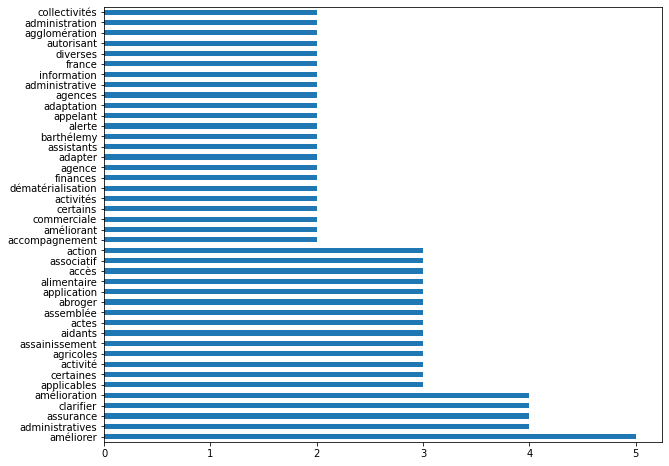

In [40]:
tab = test.category.value_counts()
tab.loc[tab>1].plot(kind="barh", figsize=(10, 8))
test

In [41]:
nlp = stanza.Pipeline('fr')

2021-12-13 09:27:34 INFO: Loading these models for language: fr (French):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |
| depparse  | gsd     |
| ner       | wikiner |

2021-12-13 09:27:34 INFO: Use device: cpu
2021-12-13 09:27:34 INFO: Loading: tokenize
2021-12-13 09:27:34 INFO: Loading: mwt
2021-12-13 09:27:34 INFO: Loading: pos
2021-12-13 09:27:34 INFO: Loading: lemma
2021-12-13 09:27:34 INFO: Loading: depparse
2021-12-13 09:27:36 INFO: Loading: ner
2021-12-13 09:27:38 INFO: Done loading processors!


In [42]:
for i in range(len(test)):
    temp = test.category.loc[i]
    temp = nlp(temp) 
    print(temp)
    temp = [word.lemma for sent in temp.sentences for word in sent.words if word.upos != "VERB" 
            and word.upos != "PRON"]
    test.category.loc[i] = temp

test.category

[
  [
    {
      "id": 1,
      "text": "biens",
      "lemma": "bien",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Plur",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 5,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "assistants",
      "lemma": "assistant",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Plur",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 10,
      "ner": "O"
    }
  ]
]


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[
  [
    {
      "id": 1,
      "text": "financière",
      "lemma": "financier",
      "upos": "ADJ",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 10,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "chômage",
      "lemma": "chômage",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 7,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "alternance",
      "lemma": "alternance",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 10,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "blanc",
      "lemma": "blanc",
      "upos": "ADJ",
      "feats": "Gender=Masc|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 5,


[
  [
    {
      "id": 1,
      "text": "aériennes",
      "lemma": "aérien",
      "upos": "ADJ",
      "feats": "Gender=Fem|Number=Plur",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 9,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "administrative",
      "lemma": "administratif",
      "upos": "ADJ",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 14,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "devoir",
      "lemma": "devoir",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 6,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "accaparement",
      "lemma": "accaparement",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "

[
  [
    {
      "id": 1,
      "text": "journée",
      "lemma": "journée",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 7,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "assurance",
      "lemma": "assurance",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 9,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "administration",
      "lemma": "administration",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 14,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "information",
      "lemma": "information",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
   

[
  [
    {
      "id": 1,
      "text": "algérie",
      "lemma": "algérie",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 7,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "conseillers",
      "lemma": "conseiller",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Plur",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 11,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "attractions",
      "lemma": "attraction",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Plur",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 11,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "administrative",
      "lemma": "administratif",
      "upos": "ADJ",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,


[
  [
    {
      "id": 1,
      "text": "contrat",
      "lemma": "contrat",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 7,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "crimes",
      "lemma": "crime",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Plur",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 6,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "globale",
      "lemma": "global",
      "upos": "ADJ",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 7,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "collectivités",
      "lemma": "collectivité",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Plur",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 13,


[
  [
    {
      "id": 1,
      "text": "enfant",
      "lemma": "enfant",
      "upos": "NOUN",
      "feats": "Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 6,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "agir",
      "lemma": "agir",
      "upos": "VERB",
      "feats": "VerbForm=Inf",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 4,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "france",
      "lemma": "france",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 6,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "information",
      "lemma": "information",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 11,
      "ner": "O"
    }
  ]
]
[


[
  [
    {
      "id": 1,
      "text": "associatif",
      "lemma": "associatif",
      "upos": "ADJ",
      "feats": "Gender=Masc|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 10,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "contenus",
      "lemma": "contenu",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Plur",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 8,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "conduire",
      "lemma": "conduire",
      "upos": "VERB",
      "feats": "VerbForm=Inf",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 8,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "déblocage",
      "lemma": "déblocage",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 9,
   

[
  [
    {
      "id": 1,
      "text": "médiateur",
      "lemma": "médiateur",
      "upos": "NOUN",
      "feats": "Gender=Masc|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 9,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "concertation",
      "lemma": "concertation",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 12,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "appelant",
      "lemma": "appeler",
      "upos": "VERB",
      "feats": "Tense=Pres|VerbForm=Part",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 8,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "calédonie",
      "lemma": "calédonie",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "

[
  [
    {
      "id": 1,
      "text": "concernés",
      "lemma": "concerner",
      "upos": "VERB",
      "feats": "Gender=Masc|Number=Plur|Tense=Past|VerbForm=Part",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 9,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "funéraire",
      "lemma": "funéraire",
      "upos": "ADJ",
      "feats": "Gender=Masc|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 9,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "assurance",
      "lemma": "assurance",
      "upos": "NOUN",
      "feats": "Gender=Fem|Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 9,
      "ner": "O"
    }
  ]
]
[
  [
    {
      "id": 1,
      "text": "abritant",
      "lemma": "abriter",
      "upos": "VERB",
      "feats": "Tense=Pres|VerbForm=Part",
      "head": 0,
      "deprel": "root",
      "start

0                   [bien]
1              [assistant]
2              [financier]
3                [chômage]
4             [alternance]
              ...         
268            [condition]
269    [cinématographique]
270            [fondation]
271           [barthélemy]
272             [contrôle]
Name: category, Length: 273, dtype: object

<AxesSubplot:>

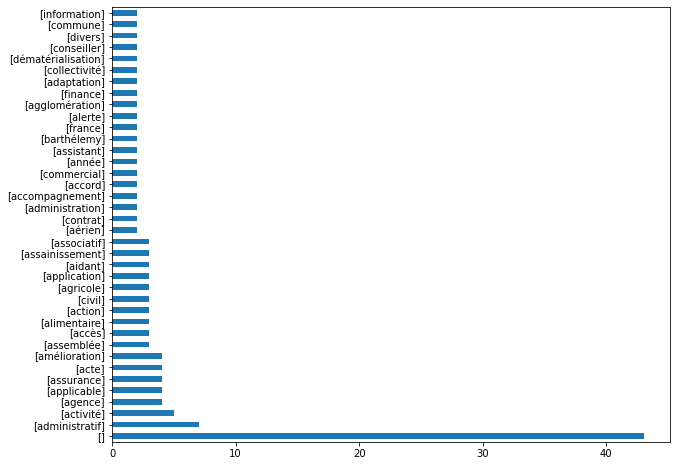

In [43]:
tab = test.category.loc[test.category != ""].value_counts()
tab.loc[tab>1].plot(kind="barh", figsize=(10, 8))